<a href="https://colab.research.google.com/github/jain-abhinav02/Sentiment-Analysis/blob/master/Airline_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary libraries
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,GRU,Dropout,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from keras.initializers import Constant

Using TensorFlow backend.


In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls
!pwd

drive  sample_data
/content


## Load the dataset

In [0]:
# import dataset into a pandas dataframe
tweets1 = pd.read_csv("drive/My Drive/Datasets/Tweets.csv")

In [5]:
# choosing a subset of the dataset to test models quickly
tweets = tweets1.iloc[:,:]
print(type(tweets))

<class 'pandas.core.frame.DataFrame'>


## Analyse the dataset

In [6]:
# a glimpse of the dataset
print(tweets.shape)
tweets.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


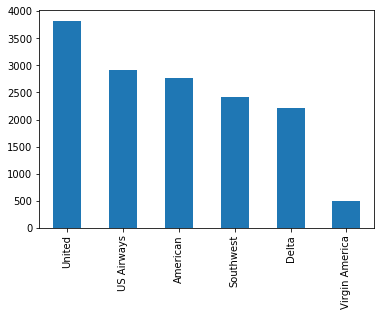

In [7]:
# Airline wise tweets count
air_wise_tweets = tweets['airline'].value_counts()
print(air_wise_tweets)
print()
print(air_wise_tweets.plot.bar())

In [8]:
print(type(air_wise_tweets))

<class 'pandas.core.series.Series'>


In [9]:
# Overall count in each of the sentiment classes 
# positive, negative, neutral
print(tweets.airline_sentiment.value_counts())

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152
AxesSubplot(0.125,0.125;0.775x0.755)


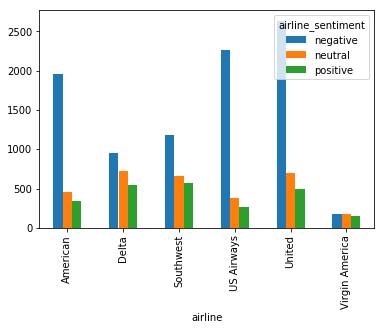

In [10]:
# Sentiment airline wise
air_wise_sent = tweets.groupby('airline').airline_sentiment.value_counts().unstack().fillna(0)
print(air_wise_sent)
print(air_wise_sent.plot.bar(stacked=False))

## Prepare the training examples

In [0]:
# One hot encode the output labels ( positive, negative , neutral)
y = tweets.iloc[:,1:2].values
encoder = OneHotEncoder()
y = encoder.fit_transform(y).toarray()

In [0]:
# Extract the tweets column and remove the prefix @airline_name
x = tweets['text']
x= x.str.extract('\w\s([\s\S]*)',expand=True)
x1 = x.iloc[:,0].values

In [13]:
# Find the maximum length of any review
print('Maximum review length: {}'.format(len(max(x1, key=len))))

Maximum review length: 175


In [0]:
maxlen=150
embedding_size = 100
MAX_NUM_WORDS = 20000

In [0]:
# Tokenize the text reviews to integer arrays
tk = Tokenizer(lower = True)
tk.fit_on_texts(x1)
x_seq = tk.texts_to_sequences(x1)
x_pad = pad_sequences(x_seq,maxlen=maxlen)

In [0]:
vocab_size = len(tk.word_counts.keys())+1

In [17]:
# Counting the number of unique words in all reviews
word_index = tk.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15670 unique tokens.


In [0]:
# splitting training and test data
x_train,x_test,y_train,y_test = train_test_split(x_pad,y,test_size=0.25,random_state=1)

In [0]:
# splitting training and validation data
valid_size = 64
x_train1 = x_train[valid_size:]
y_train1 = y_train[valid_size:]
x_val = x_train[:valid_size]
y_val = y_train[:valid_size]

In [20]:
print(x_train.shape)

(10980, 150)


## Using GloVe

In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2019-08-11 10:36:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-11 10:36:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-11 10:36:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [22]:
# processing the glove embedding txt file
GLOVE_DIR = ''
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# preparing embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## The model

In [24]:
# create a RNN model
model = Sequential()
model.add(Embedding(vocab_size,embedding_size,embeddings_initializer=Constant(embedding_matrix),input_length = maxlen,trainable=False))
#model.add(LSTM(100,return_sequences = True))
#model.add(Embedding(vocab_size,embedding_size,input_length=maxlen))
model.add(LSTM(256))

model.add(Dropout(0.5))
model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(512,activation='relu'))

model.add(Dropout(0.5))
model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(3,activation = 'softmax'))

W0811 10:36:58.517541 139872880490368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 10:36:58.559223 139872880490368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 10:36:58.598593 139872880490368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 10:36:58.899145 139872880490368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 10:36:58.908758 

In [25]:
# review the model
model.compile(loss= 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

W0811 10:36:59.235915 139872880490368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 10:36:59.264091 139872880490368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          1567100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
__________

In [32]:
# begin training on dataset
batch_size = 256
num_epochs = 21
model.fit(x_train1,y_train1,validation_data= (x_val,y_val),batch_size = batch_size, epochs= num_epochs)

Train on 10916 samples, validate on 64 samples
Epoch 1/1
10916/10916 [==============================] - 9s 821us/step - loss: 0.3267 - acc: 0.8733 - val_loss: 0.6193 - val_acc: 0.7500


In [33]:
# check accuracy on test data
scores = model.evaluate(x_test,y_test,verbose=0)
print("accuracy:",str(scores[1]))

accuracy: 0.7860655738356335


In [0]:
u=8
print(tk.sequences_to_texts(x_test[u:u+1]))
print(model.predict(x_test[u:u+1]))

['what a mess caused by the computer systems flight 719 in 3 hours late flight and now no gate for us est 26 min wait']
[[9.9953592e-01 2.0786746e-04 2.5613970e-04]]


In [0]:
encoder.categories_

[array(['negative', 'neutral', 'positive'], dtype=object)]

In [0]:
list=[['positive'],['positive'],['neutral'],['negative'],['neutral']];
arr=np.array(list)
ans=encoder.transform(list).toarray()
print(ans)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
